贝叶斯分类：
特征值选取：不包含前面450个最高频率的词，词长1到5之间，不是数字，不是停用词，不超过10000个


In [ ]:
# -*- coding: UTF-8 -*-
import os
import random
import jieba
from sklearn.naive_bayes import MultinomialNB
#import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score
import joblib
# 手写拉普拉斯修正的朴素贝叶斯
import numpy as np
import pandas as pd
import string
import warnings
warnings.filterwarnings("ignore")


"""
    函数说明:中文文本处理。将今日头条文本数据切割，保留分类名称，新闻字符串（仅含标题），新闻关键词，将新闻字符串切割成词和关键词组成。存储分类名称和词。
    Parameters:
        path - 文本存放的路径
        test_size - 测试集占比，默认占所有数据集的百分之30
    Returns:
        all_words_list - 按词频降序排序的训练集列表
        train_data_list - 训练集列表
        test_data_list - 测试集列表
        train_class_list - 训练集标签列表
        test_class_list - 测试集标签列表
"""
def TextProcessing(path, test_size=0.3):
#    folder_list = os.listdir(folder_path)  # 查看folder_path下的文件
    data_list = []  # 数据集数据
    class_list = []  # 数据集类别
    with open(path, 'r', encoding='utf-8') as f:  # 打开txt文件
        for line in f.readlines():
            line = line.strip().split("_!_") # 去除"_!_"
            # print(line)
            if (len(line) >= 5):
                strr = line[3] + line[4]    # 有标题和关键词
            else:
                strr = line[3]  # 只有标题
            word_cut = jieba.cut(strr, cut_all=False)  # 精简模式，返回一个可迭代的generator
            word_list = list(word_cut)  # generator转换为list
            word_filtered_list = []
            for v in word_list:
                if all('\u4e00' <= char <= '\u9fff' for char in v) and 1 < len(v) < 5:
                    word_filtered_list.append(v)
            data_list.append(word_filtered_list)
            class_list.append(line[2])

    # 从38万条数据中随机抽取10000条数据，并且保持各个类别的数量比例不变
    # 创建DataFrame
    df = pd.DataFrame({'text': data_list, 'class': class_list})
    sample_size = 100000

    # 确定每个类别需要抽取的数量
    class_counts = df['class'].value_counts()
    class_counts = class_counts[class_counts >= 1000]  # 每个类别至少抽取sample_size条数据
    class_ratios = class_counts / len(df)  # 计算每个类别的比例

    # 随机抽取每个类别的数据
    sampled_data = pd.DataFrame(columns=['text', 'class'])
    for cls, ratio in class_ratios.items():
        cls_data = df[df['class'] == cls]
        n_samples = int(ratio * sample_size)
        sampled_cls_data = cls_data.sample(n=n_samples, random_state=1)
        sampled_data = pd.concat([sampled_data, sampled_cls_data])

    # 随机打乱数据顺序
    sampled_data = sampled_data.sample(frac=1).reset_index(drop=True)

    # 提取抽样后的数据和类别列表
    sampled_data_list = sampled_data['text'].tolist()
    sampled_class_list = sampled_data['class'].tolist()

    # 切分训练集和测试集
    index = int(len(sampled_data_list) * (1 - test_size))
    train_data_list, test_data_list = sampled_data_list[:index], sampled_data_list[index:]
    train_class_list, test_class_list = sampled_class_list[:index], sampled_class_list[index:]


    '''
    data_class_list = list(zip(data_list, class_list))  # zip压缩合并，将数据与标签对应压缩
    random.shuffle(data_class_list)  # 将data_class_list乱序
    index = int(len(data_class_list) * test_size) + 1  # 训练集和测试集切分的索引值
    train_list = data_class_list[index:]  # 训练集
    test_list = data_class_list[:index]  # 测试集
    train_data_list, train_class_list = zip(*train_list)  # 训练集解压缩
    test_data_list, test_class_list = zip(*test_list)  # 测试集解压缩
    '''
    all_words_dict = {}  # 统计训练集词频
    for word_list in train_data_list:
        for word in word_list:
            if word in all_words_dict.keys():
                all_words_dict[word] += 1
            else:
                all_words_dict[word] = 1

    # 根据键的值倒序排序
    all_words_tuple_list = sorted(all_words_dict.items(), key=lambda f: f[1], reverse=True)
    all_words_list, all_words_nums = zip(*all_words_tuple_list)  # 解压缩
    all_words_list = list(all_words_list)  # 转换成列表
    
    return all_words_list, train_data_list, test_data_list, train_class_list, test_class_list


"""
函数说明:读取停用词文件里的内容，保存到列表
Parameters:
    words_file - 文件路径
Returns:
    words_set - 读取的内容的set集合
"""
def MakeWordsSet(words_file):
    words_set = set()  # 创建set集合
    with open(words_file, 'r', encoding='utf-8') as f:  # 打开文件
        for line in f.readlines():  # 一行一行读取
            word = line.strip()  # 去回车
            if len(word) > 0:  # 有文本，则添加到words_set中
                words_set.add(word)
    return words_set  # 返回处理结果


"""
函数说明:文本特征选取。读取所有词列表
Parameters:
    all_words_list - 训练集所有文本列表
    deleteN - 删除词频最高的deleteN个词
    stopwords_set - 指定的结束语
Returns:
    feature_words - 特征集
"""
def words_dict(all_words_list, deleteN, stopwords_set=set()):
    feature_num = 15000
    feature_words = []  # 特征列表
    n = 1
    for t in range(deleteN, len(all_words_list), 1):
        if n > feature_num:  # feature_words的维度
            break
            # 如果这个词不是数字，并且不是指定的结束语，并且单词长度大于1小于5，那么这个词就可以作为特征词
        if all_words_list[t] not in stopwords_set:
            feature_words.append(all_words_list[t])
        n += 1
    return feature_words


"""
函数说明:根据feature_words将文本向量化
Parameters:
    train_data_list - 训练集
    test_data_list - 测试集
    feature_words - 特征集
Returns:
    train_feature_list - 训练集向量化列表
    test_feature_list - 测试集向量化列表
"""
def TextFeatures(train_data_list, test_data_list, feature_words):
    punctuation_set = set(string.punctuation)
    def text_features(text, feature_words):  # 出现在特征集中，则置1
        text_words = set(text)
        features = [1 if word in text_words else 0 for word in feature_words]
        return features

    train_feature_list = [text_features(text, feature_words) for text in train_data_list]
    test_feature_list = [text_features(text, feature_words) for text in test_data_list]

    return train_feature_list, test_feature_list  # 返回结果


"""
函数说明:新闻分类器
Parameters:
    train_feature_list - 训练集向量化的特征文本
    test_feature_list - 测试集向量化的特征文本
    train_class_list - 训练集分类标签
    test_class_list - 测试集分类标签
Returns:
    test_accuracy - 分类器精度
"""


if __name__ == '__main__':
    # 文本预处理。生成倒排词表，训练集，测试集，训练标签集，测试标签集
    folder_path = "./toutiao_cat_data.txt"  # 训练集存放地址
    all_words_list, train_data_list, test_data_list, train_class_list, test_class_list = TextProcessing(folder_path,test_size=0.3)
    # 生成stopwords_set。停用词表
    stopwords_file = './stopwords_cn.txt'
    stopwords_set = MakeWordsSet(stopwords_file)

    # test_accuracy_list = []

    # 从类别名称到类别ID的映射
    id2class=['news_finance', 'news_story', 'news_travel', 'news_edu', 'news_military', 'news_game', 'news_agriculture', 'news_house', 'news_sports', 'news_car', 'news_tech', 'news_entertainment', 'news_culture', 'news_world']
    class2id = {}
    index = 0
    for i in id2class:
        class2id[i] = index
        index = index + 1
    train_class_list=[class2id[i] for i in train_class_list]
    test_class_list = [class2id[i] for i in test_class_list]

    # 生成特征词表
    feature_words = words_dict(all_words_list, 450, stopwords_set)
    a = np.array(feature_words)
    np.save("./feature_words.npy", a)  # 保存为.npy格式

    # 生成向量化的训练集和测试集(0/1)
    train_feature_list, test_feature_list = TextFeatures(train_data_list, test_data_list, feature_words)

    print("按词频降序排序的词集列表:",all_words_list[:450])
    print('词集的个数:',len(all_words_list))
    print('前500个特征词',feature_words[:500])
    print('特征词个数:',len(feature_words))
    print('训练集第一个词列表:',train_data_list[0])
    # 模型生成
    clf=MultinomialNB()
    clf.fit(train_feature_list,train_class_list)
    joblib.dump(clf, "./bayes.m")
    predict_y=clf.predict(test_feature_list)
    print(classification_report(test_class_list, predict_y, target_names=id2class))
    # acc = TextClassifier(train_feature_list, test_feature_list, train_class_list, test_class_list,c1)
    # #print(c1.cc)
    # #print(c1.fc)
    # print("acc:",acc)
    # #print("predict lable:",lable)

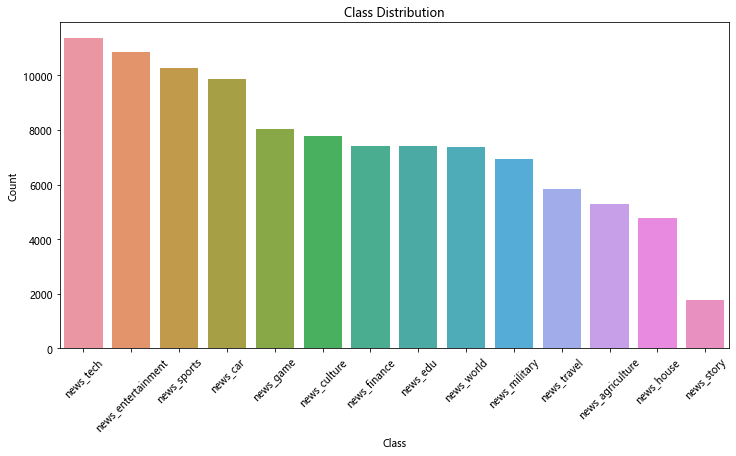

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文字体，否则无法显示中文
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei', 'Arial']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号'-'显示为方块的问题

def plot_class_distribution(class_list, id2class):
    class_counts = pd.Series(class_list).value_counts()
    class_labels = [id2class[idx] for idx in class_counts.index]
    plt.figure(figsize=(12, 6))
    sns.barplot(x=class_labels, y=class_counts.values)
    plt.xlabel('类别')
    plt.ylabel('数量')
    plt.title('训练集类别分布')
    plt.xticks(rotation=45)
    plt.show()

# 示例：可视化训练集类别分布
plot_class_distribution(train_class_list, id2class)


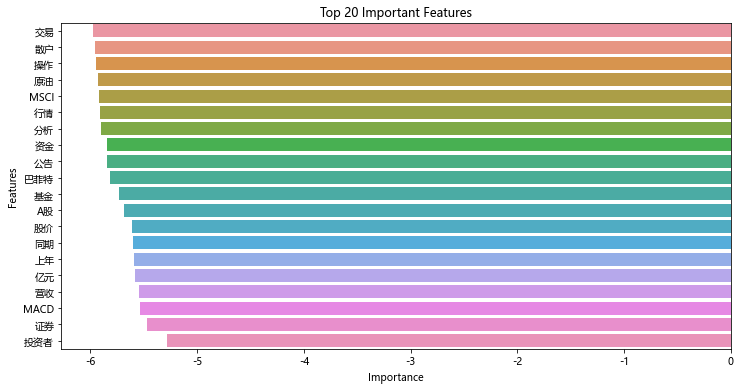

In [8]:
def plot_feature_importance(feature_words, model, top_n=20):
    feature_importance = model.coef_[0]
    sorted_idx = np.argsort(feature_importance)[-top_n:]
    top_features = np.array(feature_words)[sorted_idx]
    top_importance = feature_importance[sorted_idx]
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_importance, y=top_features)
    plt.xlabel('重要性')
    plt.ylabel('特征词')
    plt.title(f'前{top_n}个特征词')
    plt.show()

# 示例：可视化特征重要性
plot_feature_importance(feature_words, clf, top_n=20)


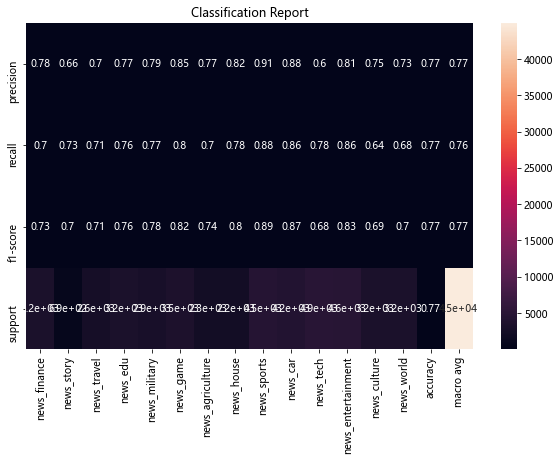

In [9]:
def plot_classification_report(y_true, y_pred, target_names):
    report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    df = pd.DataFrame(report).transpose()
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.iloc[:-1, :].T, annot=True)
    plt.title('Classification Report')
    plt.show()

# 示例：可视化分类报告
plot_classification_report(test_class_list, predict_y, id2class)
